In [1]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from imgaug import augmenters as iaa
import os
from transformers import ConvNextForImageClassification
import torchvision
import torch
import csv
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import model as mod
import train as tr
import dataset

c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
def add_ignore(path, new_path, n_values):
  df = pd.read_csv(path)
  val = list(df['img_name'].values)
  for i in range(n_values):
    num = str(i)
    x = 6-len(num)
    complete = '0'*x
    val.append(complete+num+'.jpg')
  df2 = pd.DataFrame({"img_name": val})
  df2.to_csv(new_path, index=False)

In [15]:
def add_gender(path, gender_path, new_path):
  df = pd.read_csv(path)
  df2 = pd.read_csv(gender_path)
  df['gender'] = df2["gender"]
  df.to_csv(new_path, index=False)  

In [3]:
def show(image):
    if type(image) != str:
        tensor = np.array(image)
        tensor_min, tensor_max = np.min(tensor), np.max(tensor)
        tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
        tensor = np.transpose(tensor, (1, 2, 0))
        plt.axis(False)
        plt.imshow(tensor)
    else :
        img = cv2.imread(image, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

In [2]:
def load_model(model,optimizer, path, device):
    print("=> loading checkpoint '{}'".format(path))
    checkpoint = torch.load(path, map_location=device)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
                  .format(path, checkpoint['epoch']))
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [46]:
def training(model,optimizer, train_loader, val_loader, test_loader, epochs, save_path,csv_path, device):
    best_val_mae = 10000.0
    criterion = nn.CrossEntropyLoss().to(device)

    tr_loss, tr_acc, v_loss, v_acc, mae = [],[],[],[],[]
    print(tr.validate(val_loader, model, criterion, 0, device))
    #print(tr.validate(test_loader, model, criterion, 0, device))
    for epoch in range(0, epochs):
            # train
            train_loss, train_acc = tr.train(train_loader, model, criterion, optimizer, epoch, device)

            # validate
            val_loss, val_acc, val_mae = tr.validate(val_loader, model, criterion, epoch, device)
            tr_acc.append(train_acc)
            tr_loss.append(train_loss)
            v_loss.append(val_loss)
            v_acc.append(val_acc)
            mae.append(val_mae)

            if val_mae < best_val_mae:
                    print(f"=> [epoch {epoch:03d}] best val mae was improved from {best_val_mae:.3f} to {val_mae:.3f}")
                    model_state_dict = model.state_dict()
                    model_path = save_path
                    torch.save(
                        {
                            'epoch': epoch + 1,
                            'state_dict': model_state_dict,
                            'optimizer_state_dict': optimizer.state_dict()
                        },
                        model_path
                    )
                    best_val_mae = val_mae

    load_model(model, optimizer,model_path,device)
    test_loss, test_acc, test_mae = tr.validate(test_loader, model, criterion, 0, device)
    print(test_loss, test_acc, test_mae)

    df2 = pd.DataFrame({"train_acc": tr_acc, "train_loss": tr_loss, "val_loss": v_loss, "val_acc": v_acc, "mae": mae})
    df2.to_csv(csv_path, index=False)

    return tr_loss, tr_acc, v_loss, v_acc, mae, [test_loss, test_acc, test_mae]

In [9]:
add_ignore('ignore_list.csv', 'ignore_list2000.csv', 2000)

## Dataset utils

In [4]:
class FaceDataset_synthetic_unlabelled(Dataset):
    def __init__(self, data_dir, img_size=224):
        self.img_size = img_size
        self.transform = lambda i:i
        self.x = []
        for img in os.listdir(data_dir):
            self.x.append(data_dir + '/' + img)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1)))

class FaceDataset_synthetic_labelled(Dataset):
    def __init__(self, data_dir, csv_path, img_size=224,augment=False, age_stddev=1.0):
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev
        if augment:
            self.transform = dataset.ImgAugTransform()
        else:
            self.transform = lambda i:i        

        self.x = []
        self.y = []
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            img_name = row["img_name"]
            img_path = data_dir + '/' + img_name
            self.x.append(img_path)
            self.y.append(row["predicted_age"])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn()* self.age_stddev

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

In [38]:
class FaceDataset_mix_syn_real(Dataset):
    def __init__(self, data_dirs, csv_paths, n = 1000, img_size=224,augment=False, age_stddev=1.0):
        data_dir, data_dir_synthetic = data_dirs[0], data_dirs[1]
        csv_path, csv_path_synthetic = csv_paths[0], csv_paths[1]
        
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev
        if augment:
            self.transform = dataset.ImgAugTransform()
        else:
            self.transform = lambda i:i        

        self.x = []
        self.x2 = []
        self.y = []
        self.y2 = []
        df = pd.read_csv(csv_path)
        ignore_img_names = list(pd.read_csv("ignore_list.csv")["img_name"].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]
            if img_name in ignore_img_names:
                continue
            
            img_path = data_dir + '/train/' + img_name
            self.x.append(img_path)
            self.y.append(row["apparent_age_avg"])

        df2 = pd.read_csv(csv_path_synthetic)
        for _, row in df2.iterrows():
            img_name = row["img_name"]
            img_path = data_dir_synthetic + '/' + img_name
            self.x2.append(img_path)
            self.y2.append(row["predicted_age"])

        self.x2 = self.x2[0:n//2]
        self.x = self.x[0:n//2] + self.x2
        self.y2 = self.y2[0:n//2]
        self.y = self.y[0:n//2] + self.y2

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn()* self.age_stddev

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

In [17]:
class FaceDataset_gender(Dataset):
    def __init__(self, data_dir, data_type, csv_path, gender, img_size=224,augment=False, age_stddev=1.0):
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev
        assert(gender in ("male", "female"))
        if augment:
            self.transform = dataset.ImgAugTransform()
        else:
            self.transform = lambda i:i        

        self.x = []
        self.y = []
        self.std = []
        df = pd.read_csv(csv_path)
        ignore_img_names = list(pd.read_csv("ignore_list.csv")["img_name"].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]
            if img_name in ignore_img_names:
                continue
            
            img_path = data_dir + '/'+ data_type + '/' + img_name
            if row["gender"] == gender:
                self.x.append(img_path)
                self.y.append(row["apparent_age_avg"])
                self.std.append(row["apparent_age_std"])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn()* self.std[idx]* self.age_stddev

        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

# Pipelines

## Basic

100%|██████████| 16/16 [00:02<00:00,  5.52it/s, stage=val, epoch=0, loss=20.3, acc=0.008, correct=0, sample_num=20]  


(20.33776647949219, 0.008, 32.65497340246582)


100%|██████████| 16/16 [00:02<00:00,  5.94it/s, stage=val, epoch=0, loss=0.19, acc=0.032, correct=0, sample_num=20]  


=> [epoch 000] best val mae was improved from 10000.000 to 12.008


100%|██████████| 16/16 [00:02<00:00,  6.12it/s, stage=val, epoch=3, loss=0.132, acc=0.032, correct=1, sample_num=20]


=> [epoch 003] best val mae was improved from 12.008 to 11.838


100%|██████████| 16/16 [00:02<00:00,  6.06it/s, stage=val, epoch=5, loss=0.129, acc=0.044, correct=0, sample_num=20] 


=> [epoch 005] best val mae was improved from 11.838 to 10.974


100%|██████████| 16/16 [00:02<00:00,  6.14it/s, stage=val, epoch=6, loss=0.128, acc=0.03, correct=1, sample_num=20]  


=> [epoch 006] best val mae was improved from 10.974 to 10.780


100%|██████████| 16/16 [00:02<00:00,  6.14it/s, stage=val, epoch=7, loss=0.127, acc=0.04, correct=2, sample_num=20]  


=> [epoch 007] best val mae was improved from 10.780 to 10.730


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=8, loss=0.125, acc=0.038, correct=1, sample_num=20] 


=> [epoch 008] best val mae was improved from 10.730 to 10.355


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=11, loss=0.124, acc=0.056, correct=1, sample_num=20] 


=> [epoch 011] best val mae was improved from 10.355 to 9.883


100%|██████████| 16/16 [00:02<00:00,  6.17it/s, stage=val, epoch=12, loss=0.125, acc=0.048, correct=1, sample_num=20] 


=> [epoch 012] best val mae was improved from 9.883 to 9.763


100%|██████████| 16/16 [00:02<00:00,  6.20it/s, stage=val, epoch=14, loss=0.12, acc=0.036, correct=1, sample_num=20]  


=> [epoch 014] best val mae was improved from 9.763 to 9.033


100%|██████████| 16/16 [00:02<00:00,  6.15it/s, stage=val, epoch=16, loss=0.119, acc=0.06, correct=0, sample_num=20]  


=> [epoch 016] best val mae was improved from 9.033 to 8.597


100%|██████████| 16/16 [00:02<00:00,  6.14it/s, stage=val, epoch=19, loss=0.115, acc=0.048, correct=3, sample_num=20] 


=> [epoch 019] best val mae was improved from 8.597 to 7.728


100%|██████████| 16/16 [00:02<00:00,  6.18it/s, stage=val, epoch=29, loss=0.113, acc=0.07, correct=1, sample_num=20]  


=> [epoch 029] best val mae was improved from 7.728 to 7.598


100%|██████████| 16/16 [00:02<00:00,  6.19it/s, stage=val, epoch=30, loss=0.114, acc=0.058, correct=1, sample_num=20] 


=> [epoch 030] best val mae was improved from 7.598 to 7.574


100%|██████████| 16/16 [00:02<00:00,  6.21it/s, stage=val, epoch=31, loss=0.114, acc=0.068, correct=1, sample_num=20] 


=> [epoch 031] best val mae was improved from 7.574 to 7.239


100%|██████████| 16/16 [00:02<00:00,  5.94it/s, stage=val, epoch=33, loss=0.112, acc=0.066, correct=2, sample_num=20] 


=> [epoch 033] best val mae was improved from 7.239 to 7.209


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=36, loss=0.111, acc=0.078, correct=1, sample_num=20] 


=> [epoch 036] best val mae was improved from 7.209 to 7.139


100%|██████████| 16/16 [00:02<00:00,  6.17it/s, stage=val, epoch=43, loss=0.111, acc=0.074, correct=0, sample_num=20] 


=> [epoch 043] best val mae was improved from 7.139 to 7.117


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=53, loss=0.111, acc=0.056, correct=1, sample_num=20] 


=> [epoch 053] best val mae was improved from 7.117 to 7.069


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=64, loss=0.113, acc=0.084, correct=0, sample_num=20] 


=> [epoch 064] best val mae was improved from 7.069 to 7.041


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=71, loss=0.112, acc=0.068, correct=2, sample_num=20] 


=> [epoch 071] best val mae was improved from 7.041 to 6.997


100%|██████████| 16/16 [00:02<00:00,  6.18it/s, stage=val, epoch=72, loss=0.111, acc=0.06, correct=2, sample_num=20]  


=> [epoch 072] best val mae was improved from 6.997 to 6.722


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=79, loss=0.115, acc=0.078, correct=2, sample_num=20] 


=> loading checkpoint 'train_models/res_1000_base_epoch072_0.11126_6.7219.pth'
=> loaded checkpoint 'train_models/res_1000_base_epoch072_0.11126_6.7219.pth' (epoch 73)


100%|██████████| 62/62 [00:10<00:00,  6.04it/s, stage=val, epoch=0, loss=0.12, acc=0.0607, correct=2, sample_num=26] 

0.12027371893999429 0.06066734074823053 8.620613662208463


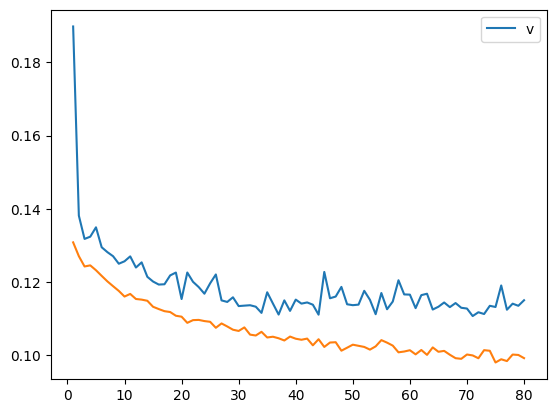

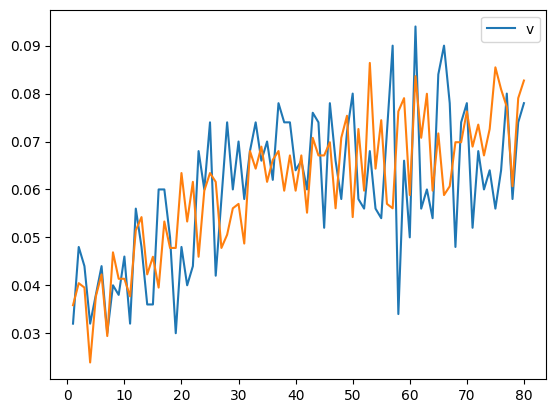

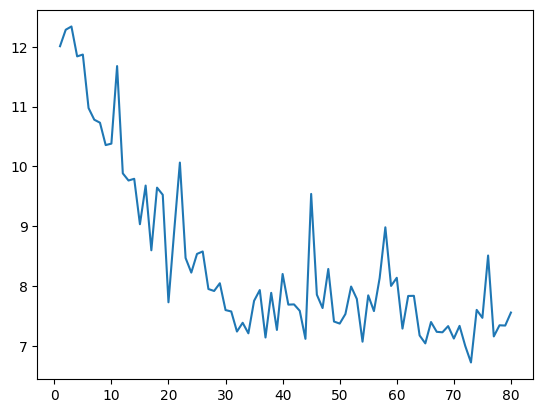

In [14]:
data_dir = './appa-real-release'
data_type = 'train'
train_dataset = dataset.FaceDataset(data_dir, data_type,ignore_path='ignore_list_test2.csv', augment = True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = dataset.FaceDataset(data_dir, 'valid')
test_dataset = dataset.FaceDataset(data_dir, 'test')
val_dataset.x = val_dataset.x[:500]
val_dataset.y = val_dataset.y[:500]
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = mod.get_model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model, optimizer, train_loader, val_loader, test_loader, 80, 'train_models/res_1000_base_','values_training_1000bas.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]


epochs = np.arange(1,81)
plt.plot(epochs, v_loss, label = 'v')
plt.plot(epochs, tr_loss)
plt.legend()
plt.show()
plt.plot(epochs, v_acc, label='v')
plt.plot(epochs, tr_acc)
plt.legend()
plt.show()
plt.plot(epochs, mae)
plt.show()


## Synthetic data

### Labelling unlabelled synthetic data 

We use the 80 epochs trained model on the whole training set.

In [ ]:
data_unlabelled_dir = 'synthetic_1000_256p/content/stylegan3/synthetic_1000_256p'

synthetic_dataset = FaceDataset_synthetic_unlabelled(data_unlabelled_dir)
synthetic_data_loader = DataLoader(synthetic_dataset, batch_size=32, shuffle=False, drop_last=False)

def label_data(synthetic_loader, model,data_dir, csv_path):
    model.eval()
    preds = []
    with torch.no_grad():
        for input in synthetic_loader:
            input = input.to(device)
            outputs = model(input)
            preds.append(torch.argmax(outputs, dim = 1).cpu().numpy())

    x = os.listdir(data_dir)
    preds = np.concatenate(preds, axis=0)
    df2 = pd.DataFrame({"img_name": x, 'predicted_age': preds})
    df2.to_csv(csv_path, index=False)

label_data(synthetic_data_loader, model, data_unlabelled_dir, 'labelled_synthetic.csv')

### Training on synthetic labelled data

100%|██████████| 16/16 [00:04<00:00,  3.25it/s, stage=val, epoch=0, loss=18.3, acc=0.004, correct=0, sample_num=20]  


(18.314916748046876, 0.004, 37.706659563410575)


100%|██████████| 16/16 [00:04<00:00,  3.32it/s, stage=val, epoch=0, loss=0.21, acc=0.024, correct=0, sample_num=20]  


=> [epoch 000] best val mae was improved from 10000.000 to 13.096


100%|██████████| 16/16 [00:04<00:00,  3.59it/s, stage=val, epoch=1, loss=0.134, acc=0.032, correct=1, sample_num=20] 


=> [epoch 001] best val mae was improved from 13.096 to 10.444


100%|██████████| 16/16 [00:04<00:00,  3.74it/s, stage=val, epoch=2, loss=0.131, acc=0.044, correct=0, sample_num=20] 


=> [epoch 002] best val mae was improved from 10.444 to 9.474


100%|██████████| 16/16 [00:04<00:00,  3.68it/s, stage=val, epoch=4, loss=0.132, acc=0.05, correct=0, sample_num=20]  


=> [epoch 004] best val mae was improved from 9.474 to 8.945


100%|██████████| 16/16 [00:04<00:00,  3.30it/s, stage=val, epoch=5, loss=0.134, acc=0.062, correct=0, sample_num=20] 


=> [epoch 005] best val mae was improved from 8.945 to 8.880


100%|██████████| 16/16 [00:04<00:00,  3.54it/s, stage=val, epoch=7, loss=0.137, acc=0.036, correct=1, sample_num=20] 


=> [epoch 007] best val mae was improved from 8.880 to 8.415


100%|██████████| 16/16 [00:04<00:00,  3.83it/s, stage=val, epoch=9, loss=0.139, acc=0.048, correct=2, sample_num=20] 


=> [epoch 009] best val mae was improved from 8.415 to 8.335


100%|██████████| 16/16 [00:04<00:00,  3.76it/s, stage=val, epoch=11, loss=0.13, acc=0.074, correct=1, sample_num=20]  


=> [epoch 011] best val mae was improved from 8.335 to 8.247


100%|██████████| 16/16 [00:04<00:00,  3.42it/s, stage=val, epoch=15, loss=0.142, acc=0.066, correct=2, sample_num=20] 


=> [epoch 015] best val mae was improved from 8.247 to 8.186


100%|██████████| 16/16 [00:04<00:00,  3.70it/s, stage=val, epoch=18, loss=0.152, acc=0.038, correct=0, sample_num=20] 


=> [epoch 018] best val mae was improved from 8.186 to 7.900


100%|██████████| 16/16 [00:04<00:00,  3.72it/s, stage=val, epoch=20, loss=0.146, acc=0.044, correct=2, sample_num=20] 


=> [epoch 020] best val mae was improved from 7.900 to 7.727


100%|██████████| 16/16 [00:02<00:00,  6.16it/s, stage=val, epoch=79, loss=0.162, acc=0.048, correct=2, sample_num=20] 


=> loading checkpoint 'train_models/res_1000_syn__epoch020_0.14599_7.7273.pth'
=> loaded checkpoint 'train_models/res_1000_syn__epoch020_0.14599_7.7273.pth' (epoch 21)


100%|██████████| 62/62 [00:10<00:00,  6.19it/s, stage=val, epoch=0, loss=0.157, acc=0.0511, correct=0, sample_num=26]


0.15720175370890402 0.051061678463094035 10.135111720070357


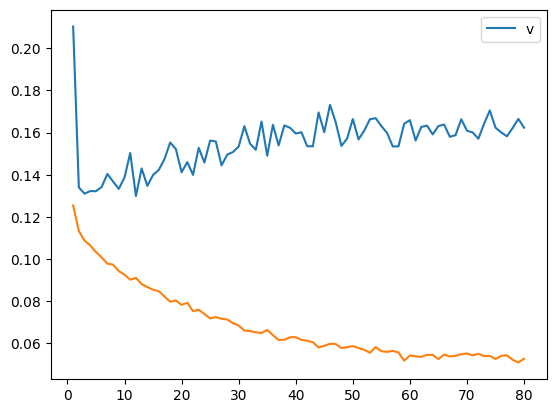

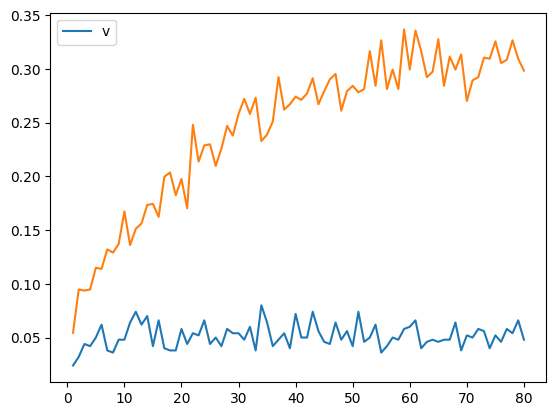

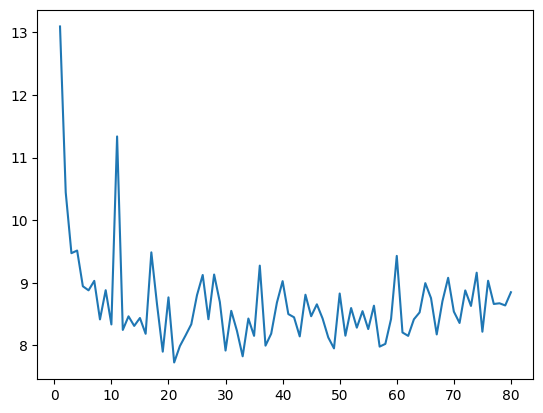

In [12]:
data_dir_synthetic = './synthetic_1000_256p/content/stylegan3/synthetic_1000_256p'
data_dir = './appa-real-release'
csv_path = 'labelled_synthetic.csv'
train_dataset = FaceDataset_synthetic_labelled(data_dir_synthetic, csv_path, augment = True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = dataset.FaceDataset(data_dir, 'valid')
test_dataset = dataset.FaceDataset(data_dir, 'test')
val_dataset.x = val_dataset.x[:500]
val_dataset.y = val_dataset.y[:500]
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = mod.get_model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model, optimizer, train_loader, val_loader, test_loader, 80, 'train_models/res_1000_syn__', "values_training_syn.csv",device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

epochs = np.arange(1,81)
plt.plot(epochs, v_loss, label = 'v')
plt.plot(epochs, tr_loss)
plt.legend()
plt.show()
plt.plot(epochs, v_acc, label='v')
plt.plot(epochs, tr_acc)
plt.legend()
plt.show()
plt.plot(epochs, mae)
plt.show()

In [ ]:
class ConvNextFinetune(nn.Module):
    """ Model using ConvNext as backbone with a linear classifier """
    def __init__(self, num_classes, frozen = False):
        super().__init__()

        self.backbone = ConvNextForImageClassification.from_pretrained("facebook/convnext-large-224")
        self.backbone.classifier = nn.Identity()
        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.classifier = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.backbone(x).logits
        x = self.classifier(x)
        return x


In [37]:
#model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
#model = torchvision.models.vit_b_16("ViT_B_16_Weights.DEFAULT")

## Mix real-synthetic data

100%|██████████| 16/16 [00:03<00:00,  5.28it/s, stage=val, epoch=0, loss=26.7, acc=0.002, correct=0, sample_num=20]  


(26.69835290527344, 0.002, 36.86811596934679)


100%|██████████| 16/16 [00:02<00:00,  6.08it/s, stage=val, epoch=0, loss=0.161, acc=0.026, correct=1, sample_num=20] 


=> [epoch 000] best val mae was improved from 10000.000 to 11.718


100%|██████████| 16/16 [00:02<00:00,  5.95it/s, stage=val, epoch=1, loss=0.147, acc=0.038, correct=0, sample_num=20] 


=> [epoch 001] best val mae was improved from 11.718 to 10.656


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, stage=val, epoch=2, loss=0.13, acc=0.028, correct=1, sample_num=20]  


=> [epoch 002] best val mae was improved from 10.656 to 9.767


100%|██████████| 16/16 [00:02<00:00,  5.76it/s, stage=val, epoch=3, loss=0.128, acc=0.038, correct=1, sample_num=20] 


=> [epoch 003] best val mae was improved from 9.767 to 9.374


100%|██████████| 16/16 [00:02<00:00,  6.12it/s, stage=val, epoch=7, loss=0.126, acc=0.042, correct=1, sample_num=20] 


=> [epoch 007] best val mae was improved from 9.374 to 8.832


100%|██████████| 16/16 [00:02<00:00,  6.06it/s, stage=val, epoch=8, loss=0.123, acc=0.044, correct=1, sample_num=20] 


=> [epoch 008] best val mae was improved from 8.832 to 8.686


100%|██████████| 16/16 [00:02<00:00,  6.10it/s, stage=val, epoch=10, loss=0.12, acc=0.058, correct=2, sample_num=20]  


=> [epoch 010] best val mae was improved from 8.686 to 8.395


100%|██████████| 16/16 [00:02<00:00,  5.59it/s, stage=val, epoch=12, loss=0.127, acc=0.07, correct=1, sample_num=20]  


=> [epoch 012] best val mae was improved from 8.395 to 8.041


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, stage=val, epoch=15, loss=0.122, acc=0.04, correct=1, sample_num=20]  


=> [epoch 015] best val mae was improved from 8.041 to 7.389


100%|██████████| 16/16 [00:02<00:00,  6.19it/s, stage=val, epoch=35, loss=0.132, acc=0.072, correct=1, sample_num=20] 


=> [epoch 035] best val mae was improved from 7.389 to 7.236


100%|██████████| 16/16 [00:02<00:00,  6.01it/s, stage=val, epoch=79, loss=0.147, acc=0.064, correct=1, sample_num=20] 


=> loading checkpoint 'train_models/res_1000_mix_epoch035_0.13236_7.2358.pth'
=> loaded checkpoint 'train_models/res_1000_mix_epoch035_0.13236_7.2358.pth' (epoch 36)


100%|██████████| 62/62 [00:10<00:00,  5.98it/s, stage=val, epoch=0, loss=0.141, acc=0.0425, correct=0, sample_num=26]


0.14100953782894493 0.042467138523761376 8.218904391776126


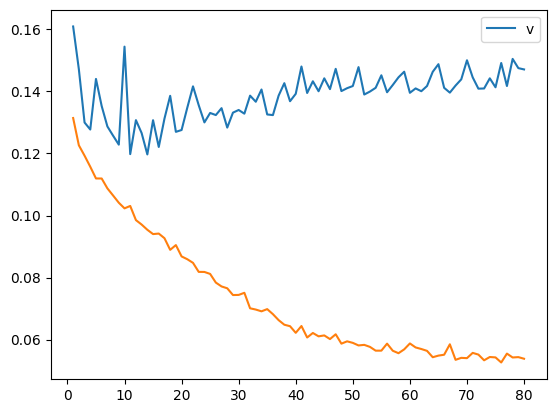

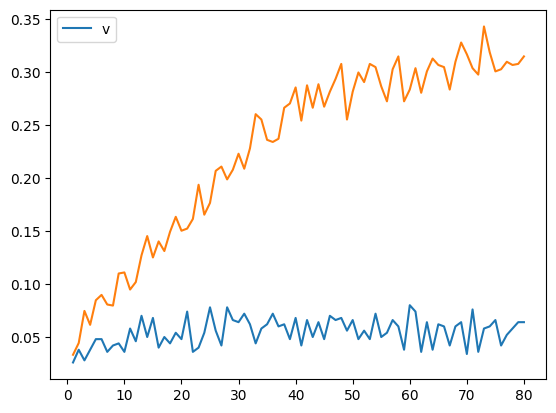

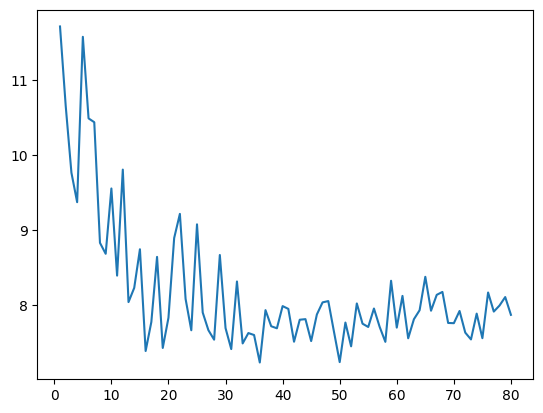

In [42]:
data_dir = ['./appa-real-release', "synthetic_1000_256p\content\stylegan3\synthetic_1000_256p"]
csv_paths = ["appa-real-release\gt_avg_train.csv", "labelled_synthetic.csv"]
train_dataset = FaceDataset_mix_syn_real(data_dir, csv_paths,n = 1000, augment = True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = dataset.FaceDataset(data_dir[0], 'valid')
test_dataset = dataset.FaceDataset(data_dir[0], 'test')
val_dataset.x = val_dataset.x[:500]
val_dataset.y = val_dataset.y[:500]
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = mod.get_model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model, optimizer, train_loader, val_loader, test_loader, 80, 'train_models/res_1000_mix_','values_training_mix_1000.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

epochs = np.arange(1,81)
plt.plot(epochs, v_loss, label = 'v')
plt.plot(epochs, tr_loss)
plt.legend()
plt.show()
plt.plot(epochs, v_acc, label='v')
plt.plot(epochs, tr_acc)
plt.legend()
plt.show()
plt.plot(epochs, mae)
plt.show()

In [34]:
train_dataset[0]

(tensor([[[141., 142., 144.,  ...,  69.,  68.,  72.],
          [141., 142., 144.,  ...,  83.,  88.,  92.],
          [141., 141., 143.,  ..., 101., 105., 109.],
          ...,
          [ 34.,  41.,  54.,  ..., 101.,  93.,  86.],
          [100., 118., 136.,  ..., 101.,  94.,  87.],
          [168., 184., 195.,  ...,  99.,  96.,  90.]],
 
         [[168., 168., 169.,  ...,  93.,  92.,  96.],
          [168., 168., 170.,  ..., 103., 108., 111.],
          [167., 168., 169.,  ..., 120., 123., 124.],
          ...,
          [ 41.,  47.,  64.,  ..., 168., 160., 153.],
          [108., 129., 146.,  ..., 168., 161., 154.],
          [179., 194., 206.,  ..., 167., 164., 157.]],
 
         [[207., 208., 211.,  ..., 161., 159., 161.],
          [207., 208., 210.,  ..., 168., 170., 173.],
          [206., 207., 209.,  ..., 178., 181., 182.],
          ...,
          [125., 130., 143.,  ..., 234., 224., 218.],
          [182., 198., 212.,  ..., 234., 226., 219.],
          [230., 239., 243.,  .

## Gender Bias

In [20]:
gender_csv = 'gender_list_test_set.csv'
train_csv = 'appa-real-release/gt_avg_test.csv'
new_path = 'test_gender.csv'

add_gender(train_csv, gender_csv, new_path)

100%|██████████| 16/16 [00:04<00:00,  3.77it/s, stage=val, epoch=0, loss=20.5, acc=0.02, correct=0, sample_num=20]  


(20.489086303710938, 0.02, 25.574561777701923)


100%|██████████| 16/16 [00:03<00:00,  4.27it/s, stage=val, epoch=0, loss=0.138, acc=0.04, correct=2, sample_num=20]  


=> [epoch 000] best val mae was improved from 10000.000 to 9.079


100%|██████████| 16/16 [00:03<00:00,  4.06it/s, stage=val, epoch=1, loss=0.136, acc=0.034, correct=3, sample_num=20]  


=> [epoch 001] best val mae was improved from 9.079 to 8.829


100%|██████████| 16/16 [00:03<00:00,  4.18it/s, stage=val, epoch=3, loss=0.119, acc=0.064, correct=2, sample_num=20] 


=> [epoch 003] best val mae was improved from 8.829 to 8.530


100%|██████████| 16/16 [00:03<00:00,  4.32it/s, stage=val, epoch=4, loss=0.119, acc=0.04, correct=0, sample_num=20]  


=> [epoch 004] best val mae was improved from 8.530 to 8.388


100%|██████████| 16/16 [00:03<00:00,  4.13it/s, stage=val, epoch=5, loss=0.118, acc=0.066, correct=0, sample_num=20] 


=> [epoch 005] best val mae was improved from 8.388 to 8.100


100%|██████████| 16/16 [00:03<00:00,  4.22it/s, stage=val, epoch=7, loss=0.119, acc=0.052, correct=3, sample_num=20] 


=> [epoch 007] best val mae was improved from 8.100 to 7.864


100%|██████████| 16/16 [00:07<00:00,  2.16it/s, stage=val, epoch=9, loss=0.114, acc=0.076, correct=3, sample_num=20] 


=> [epoch 009] best val mae was improved from 7.864 to 7.584


100%|██████████| 16/16 [00:03<00:00,  4.23it/s, stage=val, epoch=12, loss=0.114, acc=0.066, correct=0, sample_num=20] 


=> [epoch 012] best val mae was improved from 7.584 to 7.484


100%|██████████| 16/16 [00:03<00:00,  4.23it/s, stage=val, epoch=13, loss=0.112, acc=0.06, correct=3, sample_num=20]  


=> [epoch 013] best val mae was improved from 7.484 to 6.875


100%|██████████| 16/16 [00:03<00:00,  4.08it/s, stage=val, epoch=15, loss=0.111, acc=0.072, correct=1, sample_num=20] 


=> [epoch 015] best val mae was improved from 6.875 to 6.708


100%|██████████| 16/16 [00:04<00:00,  3.76it/s, stage=val, epoch=30, loss=0.109, acc=0.064, correct=3, sample_num=20] 


=> [epoch 030] best val mae was improved from 6.708 to 6.225


100%|██████████| 16/16 [00:04<00:00,  3.79it/s, stage=val, epoch=32, loss=0.11, acc=0.06, correct=0, sample_num=20]   


=> [epoch 032] best val mae was improved from 6.225 to 6.178


100%|██████████| 16/16 [00:04<00:00,  3.88it/s, stage=val, epoch=43, loss=0.109, acc=0.06, correct=2, sample_num=20]  


=> [epoch 043] best val mae was improved from 6.178 to 6.129


100%|██████████| 16/16 [00:04<00:00,  3.71it/s, stage=val, epoch=44, loss=0.11, acc=0.068, correct=1, sample_num=20]  


=> [epoch 044] best val mae was improved from 6.129 to 6.127


100%|██████████| 16/16 [00:04<00:00,  3.78it/s, stage=val, epoch=47, loss=0.11, acc=0.086, correct=2, sample_num=20]  

=> [epoch 047] best val mae was improved from 6.127 to 6.046



100%|██████████| 16/16 [00:04<00:00,  3.69it/s, stage=val, epoch=52, loss=0.109, acc=0.082, correct=0, sample_num=20] 


=> [epoch 052] best val mae was improved from 6.046 to 5.980


100%|██████████| 16/16 [00:04<00:00,  3.82it/s, stage=val, epoch=79, loss=0.112, acc=0.05, correct=1, sample_num=20]  


=> loading checkpoint 'train_models/res_2000_female_'
=> loaded checkpoint 'train_models/res_2000_female_' (epoch 53)


100%|██████████| 62/62 [00:11<00:00,  5.60it/s, stage=val, epoch=0, loss=0.121, acc=0.045, correct=1, sample_num=26] 


0.12063854782116064 0.04499494438827098 9.280948165118083


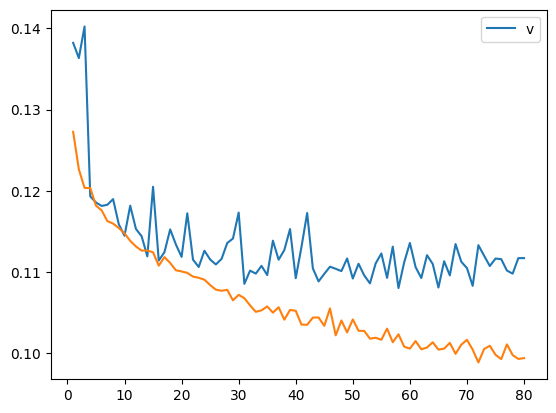

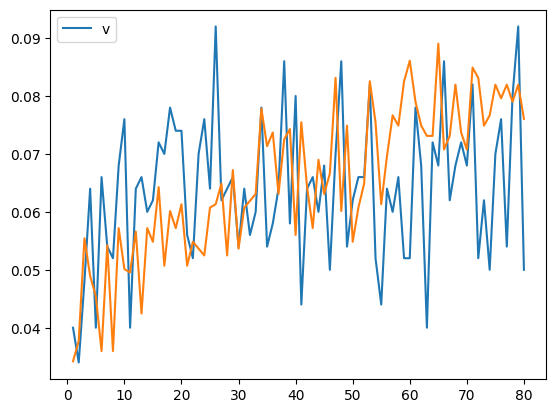

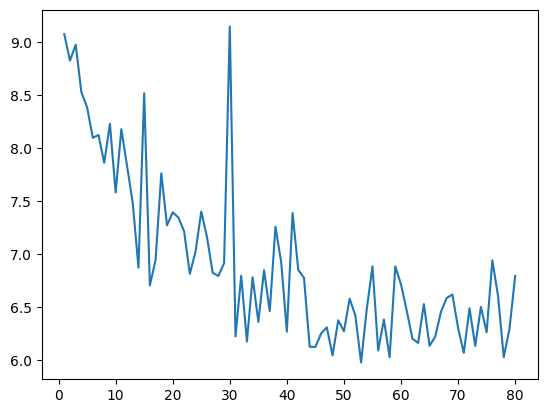

In [47]:
data_dir = './appa-real-release'
gender = 'female'
train_dataset = FaceDataset_gender(data_dir,'train', 'train_gender.csv',gender, augment = True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = FaceDataset_gender(data_dir, 'valid', 'valid_gender2.csv',gender)
test_dataset = dataset.FaceDataset(data_dir, 'test')
val_dataset.x = val_dataset.x[:500]
val_dataset.y = val_dataset.y[:500]
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = mod.get_model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model, optimizer, train_loader, val_loader, test_loader, 80, 'train_models/res_2000_female_','values_training_female.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

epochs = np.arange(1,81)
plt.plot(epochs, v_loss, label = 'v')
plt.plot(epochs, tr_loss)
plt.legend()
plt.show()
plt.plot(epochs, v_acc, label='v')
plt.plot(epochs, tr_acc)
plt.legend()
plt.show()
plt.plot(epochs, mae)
plt.show()




In [21]:
test_male_dataset = FaceDataset_gender(data_dir, 'test', 'test_gender.csv', 'male')
test_male_loader = DataLoader(test_male_dataset, batch_size=32, shuffle=False, drop_last=False)

test_female_dataset = FaceDataset_gender(data_dir, 'test', 'test_gender.csv', 'female')
test_female_loader = DataLoader(test_female_dataset, batch_size=32, shuffle=False, drop_last=False)

criterion = nn.CrossEntropyLoss().to(device)
print("female : loss, acc, mae\n", tr.validate(test_female_loader, model, criterion, 0, device))
print("male : loss, acc, mae\n", tr.validate(test_male_loader, model, criterion, 0, device))

#MALE


100%|██████████| 27/27 [00:07<00:00,  3.54it/s, stage=val, epoch=0, loss=0.131, acc=0.0336, correct=0, sample_num=2] 


female : loss, acc, mae
 (0.1308916924382857, 0.03357314148681055, 9.556542493189596)


100%|██████████| 36/36 [00:09<00:00,  3.75it/s, stage=val, epoch=0, loss=0.11, acc=0.0804, correct=2, sample_num=24] 

male : loss, acc, mae
 (0.10997153308008101, 0.08041958041958042, 7.307659896521653)


In [48]:
test_male_dataset = FaceDataset_gender(data_dir, 'test', 'test_gender.csv', 'male')
test_male_loader = DataLoader(test_male_dataset, batch_size=32, shuffle=False, drop_last=False)

test_female_dataset = FaceDataset_gender(data_dir, 'test', 'test_gender.csv', 'female')
test_female_loader = DataLoader(test_female_dataset, batch_size=32, shuffle=False, drop_last=False)

criterion = nn.CrossEntropyLoss().to(device)
print("female : loss, acc, mae\n", tr.validate(test_female_loader, model, criterion, 0, device))
print("male : loss, acc, mae\n", tr.validate(test_male_loader, model, criterion, 0, device))

#FEMALE

100%|██████████| 27/27 [00:07<00:00,  3.59it/s, stage=val, epoch=0, loss=0.116, acc=0.0624, correct=0, sample_num=2] 


female : loss, acc, mae
 (0.11612239787332732, 0.06235011990407674, 7.263918306408141)


100%|██████████| 36/36 [00:09<00:00,  3.68it/s, stage=val, epoch=0, loss=0.137, acc=0.0306, correct=1, sample_num=24]

male : loss, acc, mae
 (0.13720531438614106, 0.030594405594405596, 11.983016055446672)
